In [251]:
import pyreadr
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import (dendrogram, cut_tree, linkage)

In [357]:
def plot_dendrogram(model,filename, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.ylabel('Height')
    plt.xticks(rotation=45)
    plt.savefig('plots/{}.png'.format(filename),bbox_inches='tight')

def compute_linkage(hclust):
    """

    Create linkage matrix used to plot a dendrogram

    Follows [sklearn example](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html)

    Parameters
    ----------

    hclust : `sklearn.cluster.AgglomerativeClustering`
        Fitted hierarchical clustering object.

    Returns
    -------

    linkage_matrix : np.ndarray
        Array to be passed to `dendrogram` from `scipy.cluster.hierarchy`.

    """
    
    counts = np.zeros(hclust.children_.shape[0])
    n_samples = len(hclust.labels_)
    for i, merge in enumerate(hclust.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([hclust.children_, hclust.distances_,
                                      counts]).astype(float)
    return linkage_matrix

# Problem 1

In [2]:
problem_1_data = pyreadr.read_r('data/hw1prob1.Rdata')

In [59]:
for value in problem_1_data.values():
    problem_1_df = pd.DataFrame(value)


In [19]:
problem_1_df.columns

Index(['abandoned', 'abbeville', 'abbey', 'abbracciava', 'abilities',
       'ability', 'able', 'abode', 'about', 'above',
       ...
       'தமிழ்', 'తెలుగు', 'ಕನ್ನಡ', 'മലയാളം', 'සිංහල', 'ไทย', 'བོདཡིག',
       'မြန်မာဘာသာ', '한국어', '日本語'],
      dtype='object', length=6820)

In [60]:
problem_1_df

,abandoned,abbeville,abbey,abbracciava,abilities,ability,able,abode,about,above,...,தமிழ்,తెలుగు,ಕನ್ನಡ,മലയാളം,සිංහල,ไทย,བོདཡིག,မြန်မာဘာသာ,한국어,日本語
tmnt leo,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
tmnt raph,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tmnt mike,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
tmnt don,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
real leo,1.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,15.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
real raph,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
real mike,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
real don,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0


## Problem 1 a

In [33]:
word_counts = problem_1_df.sum(axis=1)

In [49]:
word_counts

tmnt leo     3114.0
tmnt raph    1976.0
tmnt mike    3330.0
tmnt don     2143.0
real leo     8962.0
real raph    6524.0
real mike    4618.0
real don     1766.0
dtype: float64

### Determine the number of documents that contain each word

This will allow me to keep track of number of documents that contain the given word, by making it 1 if it contains the word, 0 otherwise

In [50]:
documents_count_df = problem_1_df.applymap(lambda x: 1 if x != 0 and pd.notna(x) else 0)

/var/folders/9l/1xgvrcy5545b3kwy8sbpb_7h0000gn/T/ipykernel_16336/2945791922.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  documents_count_df = problem_1_df.applymap(lambda x: 1 if x != 0 and pd.notna(x) else 0)


Sum each column to get n_w for each word

In [54]:
n_w = documents_count_df.sum()
n_w

abandoned      2
abbeville      1
abbey          1
abbracciava    1
abilities      4
              ..
ไทย            4
བོདཡིག         3
မြန်မာဘာသာ     2
한국어            6
日本語            4
Length: 6820, dtype: int64

In [47]:
dtm1 = pd.DataFrame(columns=problem_1_df.columns)
for k,v in word_counts.items():
    dtm1.loc[k] = problem_1_df.loc[k]/v

In [63]:
D = 8

In [75]:
dtm1 = dtm1 * np.log(D/dtm1.columns.map(n_w.to_dict()))

### dtm2 - first scale by IDF and then normalize by word count

In [77]:
dtm2 = pd.DataFrame(columns=problem_1_df.columns)

In [81]:
dtm2 = problem_1_df * np.log(D/dtm2.columns.map(n_w.to_dict()))

In [83]:
for k,v in word_counts.items():
    dtm2.loc[k] = dtm2.loc[k]/v

### dtm1 vs dtm2

They are identical. This makes since because you are only apply transformations in a different order. Both IDF and word count normalization depend on the original data and it does not matter which order you apply.

In [88]:
dtm1

,abandoned,abbeville,abbey,abbracciava,abilities,ability,able,abode,about,above,...,தமிழ்,తెలుగు,ಕನ್ನಡ,മലയാളം,සිංහල,ไทย,བོདཡིག,မြန်မာဘာသာ,한국어,日本語
tmnt leo,0.000445,0.000000,0.000000,0.00000,0.000445,0.000000,0.000000,0.000000,0.0,0.000223,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000092,0.000000
tmnt raph,0.000000,0.000000,0.001052,0.00000,0.000351,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
tmnt mike,0.000000,0.000000,0.000000,0.00000,0.000416,0.000416,0.000208,0.000624,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000086,0.000000
tmnt don,0.000000,0.000000,0.000000,0.00000,0.000323,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
real leo,0.000155,0.000000,0.000000,0.00000,0.000000,0.000619,0.000077,0.000000,0.0,0.000155,...,0.000109,0.000155,0.000155,0.000077,0.000155,0.000077,0.000109,0.000155,0.000032,0.000077
real raph,0.000000,0.000319,0.000000,0.00000,0.000000,0.000000,0.000106,0.000000,0.0,0.000106,...,0.000150,0.000000,0.000000,0.000106,0.000000,0.000106,0.000150,0.000000,0.000044,0.000106
real mike,0.000000,0.000000,0.000000,0.00045,0.000000,0.000000,0.000150,0.000000,0.0,0.000150,...,0.000212,0.000300,0.000300,0.000150,0.000300,0.000150,0.000212,0.000300,0.000062,0.000150
real don,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000392,0.000000,0.000392,0.000000,0.000000,0.000163,0.000392


In [89]:
dtm2

,abandoned,abbeville,abbey,abbracciava,abilities,ability,able,abode,about,above,...,தமிழ்,తెలుగు,ಕನ್ನಡ,മലയാളം,සිංහල,ไทย,བོདཡིག,မြန်မာဘာသာ,한국어,日本語
tmnt leo,0.000445,0.000000,0.000000,0.00000,0.000445,0.000000,0.000000,0.000000,0.0,0.000223,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000092,0.000000
tmnt raph,0.000000,0.000000,0.001052,0.00000,0.000351,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
tmnt mike,0.000000,0.000000,0.000000,0.00000,0.000416,0.000416,0.000208,0.000624,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000086,0.000000
tmnt don,0.000000,0.000000,0.000000,0.00000,0.000323,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
real leo,0.000155,0.000000,0.000000,0.00000,0.000000,0.000619,0.000077,0.000000,0.0,0.000155,...,0.000109,0.000155,0.000155,0.000077,0.000155,0.000077,0.000109,0.000155,0.000032,0.000077
real raph,0.000000,0.000319,0.000000,0.00000,0.000000,0.000000,0.000106,0.000000,0.0,0.000106,...,0.000150,0.000000,0.000000,0.000106,0.000000,0.000106,0.000150,0.000000,0.000044,0.000106
real mike,0.000000,0.000000,0.000000,0.00045,0.000000,0.000000,0.000150,0.000000,0.0,0.000150,...,0.000212,0.000300,0.000300,0.000150,0.000300,0.000150,0.000212,0.000300,0.000062,0.000150
real don,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000392,0.000000,0.000392,0.000000,0.000000,0.000163,0.000392


## Problem 1 b

In [90]:
dtm3 = pd.DataFrame(columns=problem_1_df.columns)
for k,v in word_counts.items():
    dtm3.loc[k] = problem_1_df.loc[k]/v

In [92]:
tmnt_mike = np.array(dtm3.loc['tmnt mike'])

Iterate through the data frame and calculate the euclidean norm for each vector compared to `tmnt_mike`

The closest document is `tmnt raph`

In [101]:
for row in dtm3.iterrows():
    euclidean_distance = np.linalg.norm(tmnt_mike - np.array(row[1]))
    print('{}: {}'.format(row[0], euclidean_distance))

tmnt leo: 0.04118467877954197
tmnt raph: 0.03782949128933655
tmnt mike: 0.0
tmnt don: 0.042006124349499935
real leo: 0.04887327167743683
real raph: 0.04487836641687292
real mike: 0.047500179860007326
real don: 0.06376091296934941


## Problem 1c

Complete linkage does a better job when K=2 because it creates to groups, one of turtles and one of the artists. 

In [105]:
euclidean_distances = pdist(dtm3, metric='euclidean')
distance_matrix = squareform(euclidean_distances)

In [106]:
distance_df = pd.DataFrame(distance_matrix, index=dtm3.index, columns=dtm3.index)
distance_df

,tmnt leo,tmnt raph,tmnt mike,tmnt don,real leo,real raph,real mike,real don
tmnt leo,0.000000,0.038599,0.041185,0.044445,0.042532,0.049604,0.064754,0.067113
tmnt raph,0.038599,0.000000,0.037829,0.042870,0.054986,0.046176,0.066762,0.068849
tmnt mike,0.041185,0.037829,0.000000,0.042006,0.048873,0.044878,0.047500,0.063761
tmnt don,0.044445,0.042870,0.042006,0.000000,0.053655,0.050400,0.061904,0.053722
real leo,0.042532,0.054986,0.048873,0.053655,0.000000,0.039363,0.053363,0.055306
real raph,0.049604,0.046176,0.044878,0.050400,0.039363,0.000000,0.050380,0.054376
real mike,0.064754,0.066762,0.047500,0.061904,0.053363,0.050380,0.000000,0.057994
real don,0.067113,0.068849,0.063761,0.053722,0.055306,0.054376,0.057994,0.000000


In [347]:
HClust = AgglomerativeClustering
hc_comp = HClust(distance_threshold=0,n_clusters=None ,linkage='complete')
hc_comp.fit(dtm3)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)

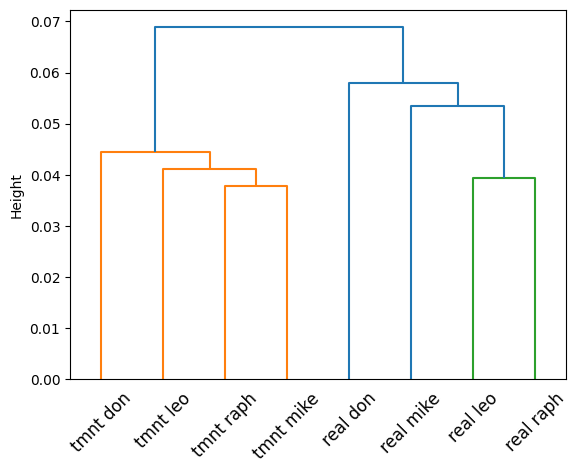

In [358]:
plot_dendrogram(hc_comp, filename = 'tmnt_complete',labels = ["tmnt leo","tmnt raph","tmnt mike","tmnt don","real leo","real raph","real mike","real don"])

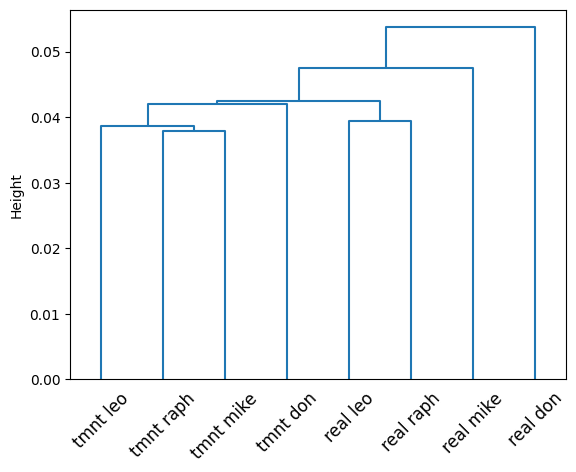

In [359]:
hc_sing = HClust(distance_threshold=0,n_clusters=None ,linkage='single')
hc_sing.fit(dtm3)
plot_dendrogram(hc_sing, filename = "tmnt_single",labels = ["tmnt leo","tmnt raph","tmnt mike","tmnt don","real leo","real raph","real mike","real don"])

## Problem 1d

In [110]:
word_counts = problem_1_df.sum()

In [117]:
first_20 = pd.DataFrame(word_counts.sort_values(ascending=False), columns=['count']).head(n=20)
first_20

,count
the,2664.0
and,1127.0
his,636.0
was,453.0
leonardo,342.0
that,297.0
for,282.0
with,279.0
michelangelo,277.0
raphael,212.0


In [123]:
first_20.sum()/word_counts.sum()

count    0.243425
dtype: float64

In [127]:
running_sum = 0
words = 0
for count in word_counts.sort_values(ascending=False):
    words+=1
    running_sum+=count
    if running_sum/word_counts.sum()>=0.5:
        print(words)
        print(running_sum)
        break

254
16231.0


## Problem 1e

In [139]:
num_of_words = 6820
largest_count = 2664.0
zipf_law_values  = np.array([largest_count/(i+1) for i in range(num_of_words)])
actual_values = word_counts.sort_values(ascending=False).values


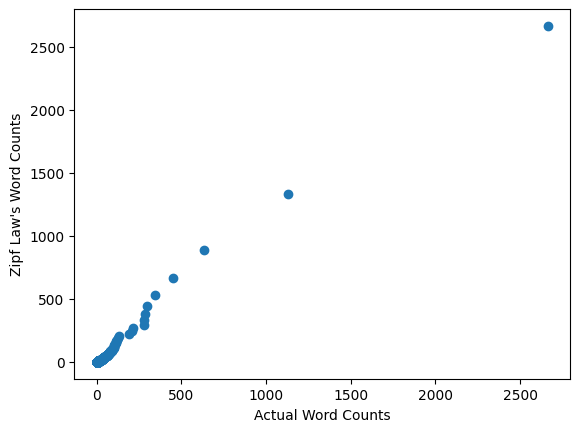

In [356]:
plt.scatter(actual_values,zipf_law_values)
plt.xlabel('Actual Word Counts')
plt.ylabel('Zipf Law\'s Word Counts')
plt.savefig('plots/zipf_law.png')

# Problem 3

In [170]:
problem_3_data = pyreadr.read_r('data/hw1prob3.Rdata')

In [288]:
for k,v in problem_3_data.items():
    if k == 'x':
        x = pd.DataFrame(v)
    if k == 'd':
        distance = pd.DataFrame(v)

In [289]:
x.head()

,0,1
0,-0.313227,0.755891
1,0.091822,0.194922
2,-0.417814,-0.310620
3,0.797640,-1.107350
4,0.164754,0.562465


In [307]:
if isinstance(distances, pd.DataFrame):
    print('yes')

yes


In [332]:
def h_cluster(data: pd.DataFrame, 
              linkage: str, 
              num_clusters: int, 
              metric: str = 'euclidean', 
              distances: pd.DataFrame = None,
              figure_name: str = 'plot')-> None:
    df = data.copy()
    hclust = HClust(distance_threshold=0,n_clusters=None,metric=metric, linkage=linkage)
    if isinstance(distances, pd.DataFrame):
        hclust.fit(distances)
    else:
        hclust.fit(df)
    linkage_matrix = compute_linkage(hclust)
    data_labels = cut_tree(linkage_matrix,num_clusters)
    df['cluster'] = data_labels
    sns.scatterplot(x=df[0],y=df[1], hue=df['cluster'], palette = sns.color_palette("Set2")[0:num_clusters])
    plt.savefig('plots/{}.png'.format(figure_name))
    
    return None

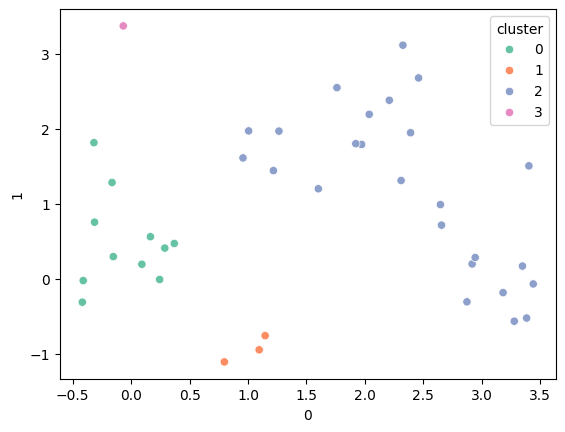

In [314]:
h_cluster(data = x, linkage='single', num_clusters=4, figure_name='single_linkage')

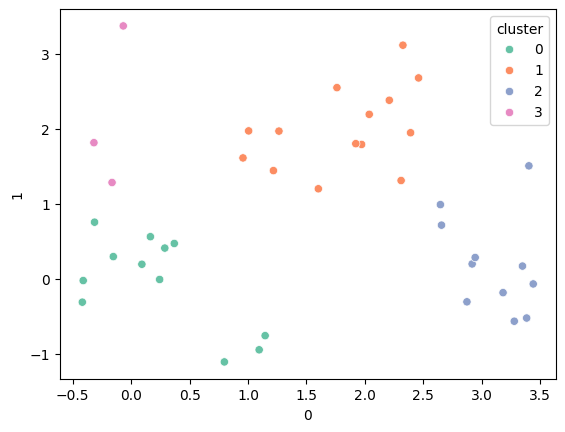

In [315]:
h_cluster(data = x, linkage='complete', num_clusters=4, figure_name='complete_linkage')

In [295]:
distances = pd.read_csv('data/distances.csv')
distances = distances.drop(columns='Unnamed: 0', axis=1)

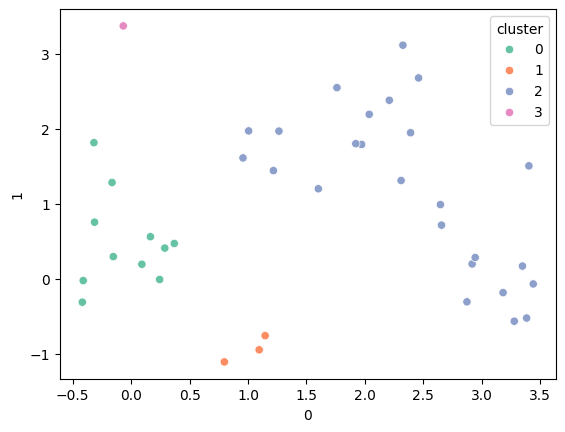

In [316]:
h_cluster(data = x, metric='precomputed', distances=distances**2, linkage='single', num_clusters=4, figure_name='single_squared')

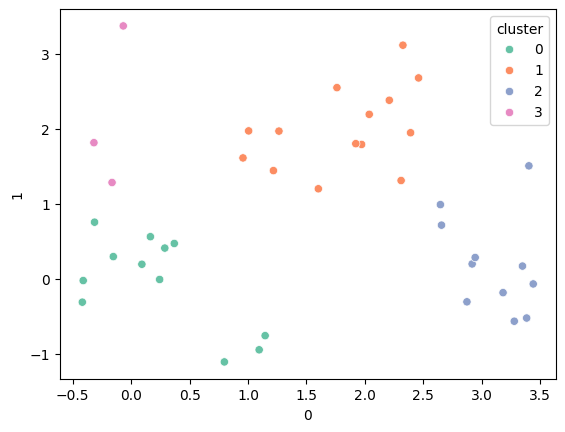

In [317]:
h_cluster(data = x, metric='precomputed', distances=distances**2, linkage='complete', num_clusters=4, figure_name='complete_squared')

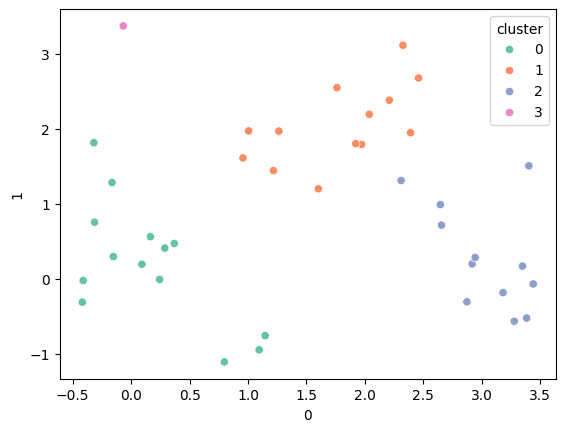

In [330]:
h_cluster(data = x, linkage='average', num_clusters=4, figure_name='average_linkage_4')

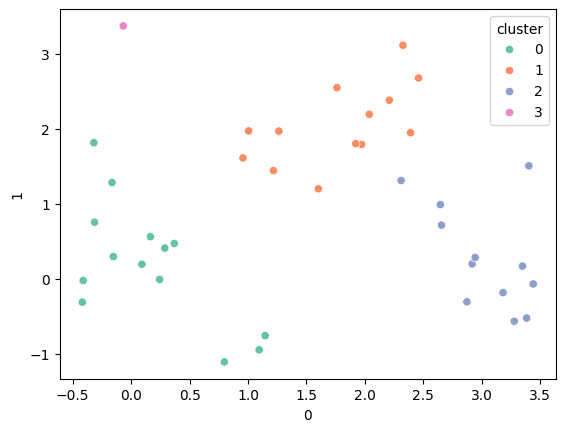

In [331]:
h_cluster(data = x, metric='precomputed', distances=distances**2, linkage='average', num_clusters=4, figure_name='average_squared_4')

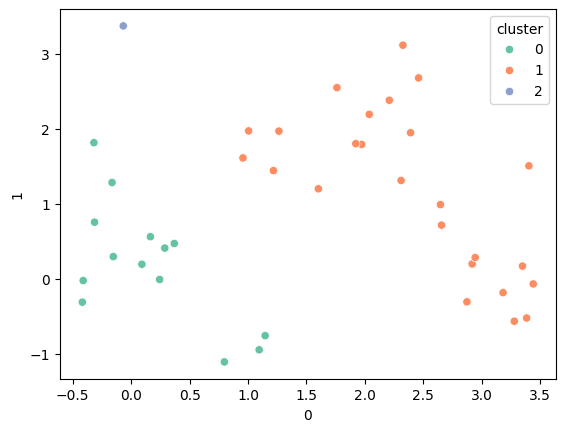

In [333]:
h_cluster(data = x, linkage='average', num_clusters=3, figure_name='average_linkage_3')

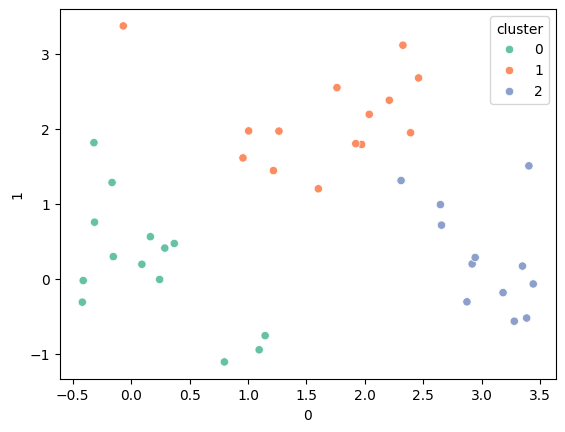

In [334]:
h_cluster(data = x, metric='precomputed', distances=distances**2, linkage='average', num_clusters=3, figure_name='average_squared_3')